In [2]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, optimizers, datasets

latent_dim = 32
height = 32
width = 32
channels = 3




# GAN Generator Network (generator 네트워크는 (latent_dim,)크기의 벡터를 (32, 32, 3)크기의 이미지로 매핑)
generator_input = tf.keras.Input(shape=(latent_dim,))

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x) # 입력을 16*16 크기의 채널 128개를 가진 feature map으로 변환

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) # Upsampling
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = models.Model(generator_input, x)
generator.summary()




# GAN Discriminator Network (32, 32, 3)크기의 생성된 이미지가 진짜일 확률을 추정하여 이진 값으로 매핑
discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
    # optimizer에서 지정한 값으로 gradient clipping, 안정된 훈련을 위해 learning rate decay
discriminator.compile(optimizer = discriminator_optimizer, loss='binary_crossentropy')




# GAN Network
discriminator.trainable = False 
# Model 클래스 객체의 trainable 속성을 False로 하면 이 모델이 다른 모델에 층처럼 추가되었을 때 학습하지 않도록 만들어준다.
# discriminator.fit()메서드로 판별자에 속한 Layer 클래스 객체의 가중치를 학습하는 데는 영향을 미치지 않는다.


gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = models.Model(gan_input, gan_output)

gan_optimizer = optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer = gan_optimizer, loss='binary_crossentropy')


def show_images(img_generated):

    plt.imshow(img_generated)
    plt.tight_layout()
    plt.show()


# Definition of Training GAN
def train(iterations, print_step=100):
    
    (x_train, y_train), (_, _) = datasets.cifar10.load_data() # x_train : (50000, 32, 32, 3)
    x_train = x_train[y_train.flatten() == 0] # x_train : (5000, 32, 32, 3)
    x_train = x_train.reshape((x_train.shape[0],) + (height, width, channels)).astype('float32') / 255. # 정규화

    batch_size = 20
    save_dir = '/home/hongbeom/Workspace/JKP/DCGAN'
    start = 0
    
    for step in range(iterations):
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim)) # 잠재 공간에서 무작위로 포인트 샘플링
        
        generated_images = generator.predict(random_latent_vectors) # 가짜 이미지 디코딩
        stop = start + batch_size
        real_images = x_train[start:stop]
        combined_images = np.concatenate([generated_images, real_images]) # 진짜 이미지와 연결
        labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))]) # 진짜와 가짜 이미지 레이블 병합
        labels += 0.05 * np.random.random(labels.shape)
        
        d_loss = discriminator.train_on_batch(combined_images, labels) # discriminator training
        
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim)) # 다시 한 번 무작위 샘
        misleading_targets = np.zeros((batch_size, 1)) # 모두 '진짜 이미지'라고 레이블 생성 (사실 가짜)
        
        g_loss = gan.train_on_batch(random_latent_vectors, misleading_targets) # generator training (Freezing Discriminator in GAN Model)
        
        start += batch_size
        if start > len(x_train) - batch_size:
            start = 0
            
        if (step>0) and (step % print_step == 0):
            gan.save_weights('gan.h5')
            
            print("Discriminator Loss at step %.6d : %.4f" %(step, d_loss))
            print("Generator Loss at step %.6d : %.4f \n" %(step, g_loss))
            
            img_generated = image.array_to_img(generated_images[0] * 255., scale = False)
            show_images(img_generated)
            img_generated.save(os.path.join(save_dir, 'generated_airplane' + str(step) + '.png'))
            
            img = image.array_to_img(real_images[0] * 255., scale = False)
            img.save(os.path.join(save_dir, 'real_airplane' + str(step) + '.png'))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

In [4]:
import os
currentPath = os.getcwd()
print(currentPath)
os.chdir('/home/hongbeom/Workspace/JKP/DCGAN')


/home/hongbeom/Workspace/JKP/DCGAN


Discriminator Loss at step 001000 : 0.6978
Generator Loss at step 001000 : 0.7785 



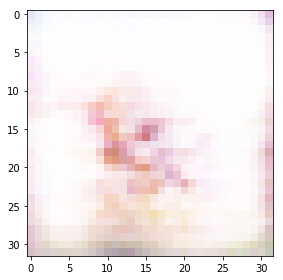

Discriminator Loss at step 002000 : 0.6920
Generator Loss at step 002000 : 0.7099 



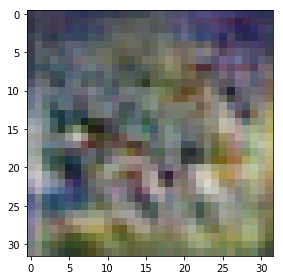

Discriminator Loss at step 003000 : 0.7188
Generator Loss at step 003000 : 0.8137 



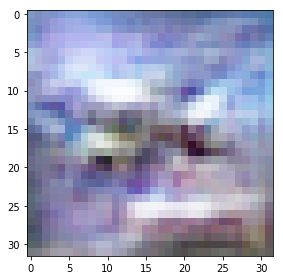

Discriminator Loss at step 004000 : 0.7028
Generator Loss at step 004000 : 0.7150 



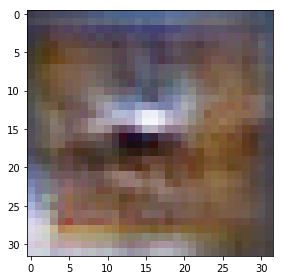

Discriminator Loss at step 005000 : 0.6942
Generator Loss at step 005000 : 0.8877 



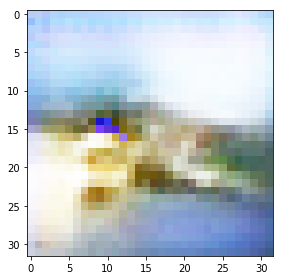

Discriminator Loss at step 006000 : 0.6971
Generator Loss at step 006000 : 0.7596 



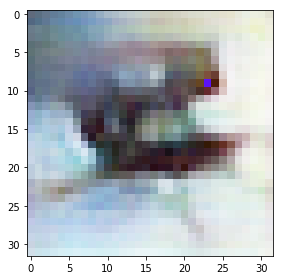

Discriminator Loss at step 007000 : 0.6932
Generator Loss at step 007000 : 0.7827 



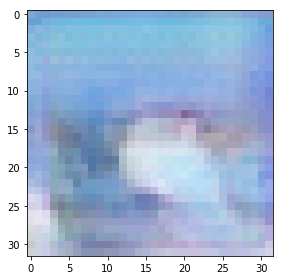

Discriminator Loss at step 008000 : 0.6833
Generator Loss at step 008000 : 0.7608 



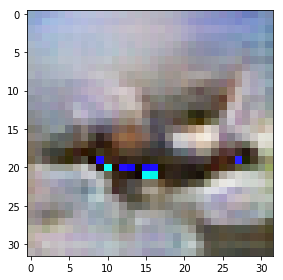

Discriminator Loss at step 009000 : 0.7102
Generator Loss at step 009000 : 0.7649 



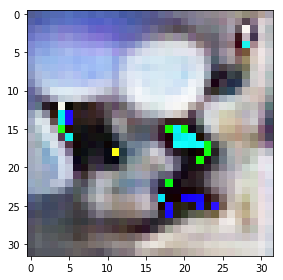

Discriminator Loss at step 010000 : 0.6988
Generator Loss at step 010000 : 0.7985 



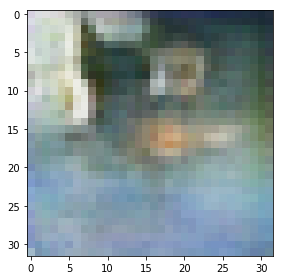

Discriminator Loss at step 011000 : 0.6904
Generator Loss at step 011000 : 0.7539 



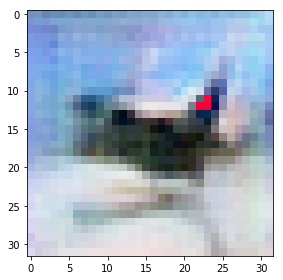

Discriminator Loss at step 012000 : 0.6988
Generator Loss at step 012000 : 0.7453 



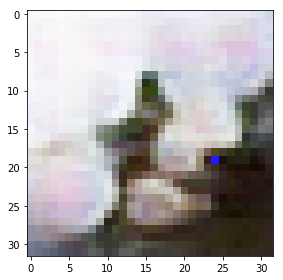

Discriminator Loss at step 013000 : 0.6834
Generator Loss at step 013000 : 0.7375 



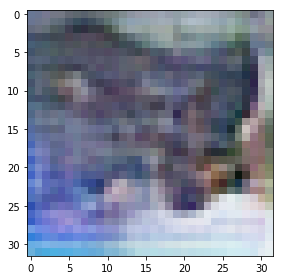

Discriminator Loss at step 014000 : 0.6932
Generator Loss at step 014000 : 1.1402 



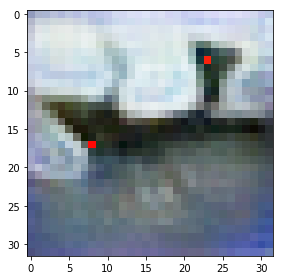

Discriminator Loss at step 015000 : 2.1960
Generator Loss at step 015000 : 1.7042 



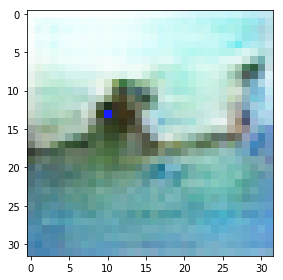

Discriminator Loss at step 016000 : 0.6624
Generator Loss at step 016000 : 0.7845 



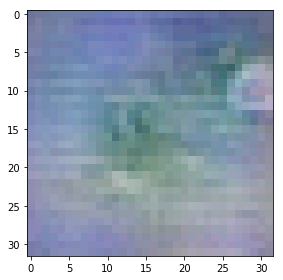

Discriminator Loss at step 017000 : 0.7015
Generator Loss at step 017000 : 0.8018 



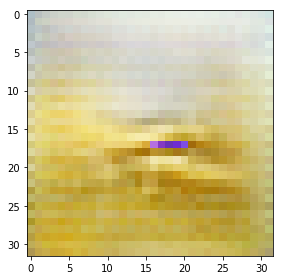

Discriminator Loss at step 018000 : 0.6901
Generator Loss at step 018000 : 0.8227 



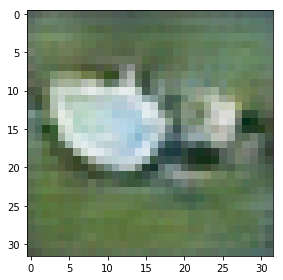

Discriminator Loss at step 019000 : 0.4681
Generator Loss at step 019000 : 4.4048 



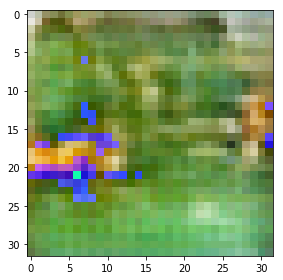

Discriminator Loss at step 020000 : 0.6711
Generator Loss at step 020000 : 0.8778 



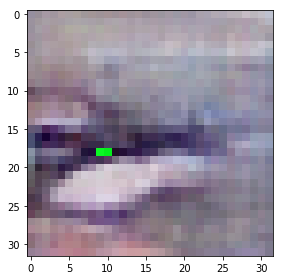

Discriminator Loss at step 021000 : 0.7202
Generator Loss at step 021000 : 0.7656 



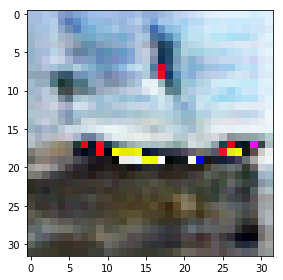

Discriminator Loss at step 022000 : 0.7119
Generator Loss at step 022000 : 0.7783 



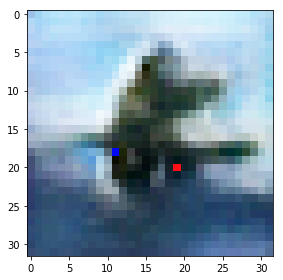

Discriminator Loss at step 023000 : 3.5763
Generator Loss at step 023000 : 1.1187 



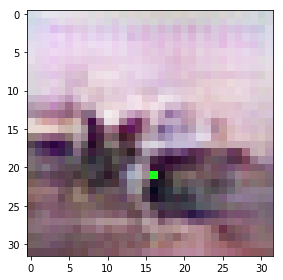

Discriminator Loss at step 024000 : 0.7917
Generator Loss at step 024000 : 0.7626 



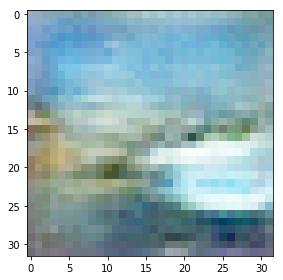

Discriminator Loss at step 025000 : 0.6444
Generator Loss at step 025000 : 0.7229 



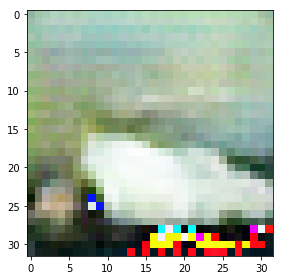

Discriminator Loss at step 026000 : 0.7196
Generator Loss at step 026000 : 1.0467 



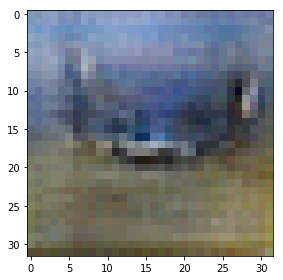

Discriminator Loss at step 027000 : 0.6805
Generator Loss at step 027000 : 0.8556 



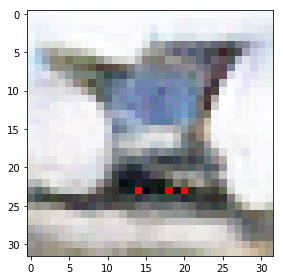

Discriminator Loss at step 028000 : 0.7034
Generator Loss at step 028000 : 0.9299 



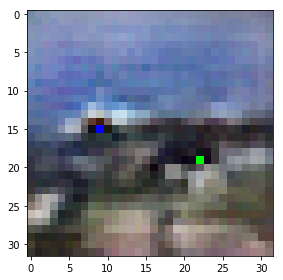

Discriminator Loss at step 029000 : 0.7947
Generator Loss at step 029000 : 0.8298 



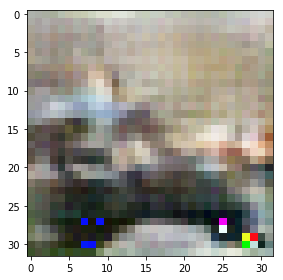

CPU times: user 30min 2s, sys: 2min 38s, total: 32min 41s
Wall time: 43min 5s


In [5]:
%%time
train(30000, 1000)